# MNIST Inpainting con imagen de referencia
En este experimento se implementará y entrenará un modelo de image inpainting sobre el dataset de MNIST, utilizando una segunda imágen como referencia. 

Se entrenará un modelo capaz de regenerar secciones faltantes dentro de imágenes de MNIST de forma realista. El modelo consiste de Deep Convolutional Networks, y se entrenará mediante un framework GAN, es decir, se entrenará un modelo generador y un discriminador en simultaneo.

En esta versión, el generador recibe tanto la imágen con la sección a ser regenerada, como otra imagen de referencia del mismo dígito.

## Imports y setup

In [1]:
# to generate gifs
!pip install imageio

In [2]:
import tensorflow as tf
tf.enable_eager_execution()

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time

from IPython import display

In [3]:
print(tf.__version__)

1.11.0


## Carga del dataset

Usaremos el dataset de MNIST para entrenar al generador y al discriminador, el cual viene incluido dentro de la API de tf.keras. Del dataset de training se utiliza un 90% para el entrenamiento, y se separa un 10% para validación. En cada uno de estos datasets se separa un conjunto de imágenes para ser enmascaradas (las cuales seran regeneradas por el generador), y otro conjunto de imágenes para usar de referencia. A su vez, en el dataset de entrenamiento se separa un tercer conjunto de imágenes reales para entrenar al discriminador.

In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
print(train_images.shape)
print(train_labels.shape)

(60000, 28, 28)
(60000,)


In [5]:
def mask(image, reference_image):
  """
  Applies a mask of zeroes of size 7x7 at the center of the image.
  Returns a tuple of the masked image and the original image.
  """
  upper_edge = tf.ones([10,28,1], tf.float32)
  lower_edge = tf.ones([11,28,1], tf.float32)
  
  middle_left = tf.ones([7,10,1], tf.float32)
  middle_right = tf.ones([7,11,1], tf.float32)
  
  zeros = tf.zeros([7,7,1], tf.float32)
  
  middle = tf.concat([middle_left, zeros, middle_right], axis=1)
  mask = tf.concat([upper_edge, middle, lower_edge], axis=0)
  
  return (image * mask, image, reference_image)
  

In [6]:
def create_reference_dictionary(reference_labels):
  """
  Returns a dictionary where each key corresponds to an MNIST label (0-9), 
  and each value is a list of the indeces from reference_labels containing the key label.
  """
  reference_dict = {}
  for label in range(10):
    reference_dict[label] = np.where(reference_labels == label)[0]
  return reference_dict

In [7]:
def get_references(reference_pool, labels, reference_dict):
  reference_images = []
  for label in labels:
    reference_idx = np.random.choice(reference_dict[label])
    reference_images.append(reference_pool[reference_idx])
  return np.array(reference_images)

### Training set

In [8]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

# Normalize the images to [-1, 1]
train_images = (train_images - 127.5) / 127.5
test_images = (test_images - 127.5) / 127.5

indeces = np.random.permutation(len(train_images))
train_images = train_images[indeces]
train_labels = train_labels[indeces]

# Split between training and validation sets
TRAINING_SAMPLES = int(len(train_images) * 0.9)
train_set_images = train_images[:TRAINING_SAMPLES,:,:,:]
validation_set_images = train_images[TRAINING_SAMPLES:,:,:,:]

# TODO: generar diccionario de referencias para validation.

train_set_labels = train_labels[:TRAINING_SAMPLES]
validation_set_labels = train_labels[TRAINING_SAMPLES:]

# Split training images between masked, full, and reference images.
REAL_IMAGES_BOUNDRY = int(len(train_set_images) * 0.4)
MASKED_IMAGES_BOUNDRY = REAL_IMAGES_BOUNDRY + int(len(train_set_images) * 0.4)

train_full_images = train_set_images[:REAL_IMAGES_BOUNDRY,:,:,:]
train_masked_images = train_set_images[REAL_IMAGES_BOUNDRY:MASKED_IMAGES_BOUNDRY,:,:,:]
train_reference_images = train_set_images[MASKED_IMAGES_BOUNDRY:,:,:,:]

train_full_labels = train_set_labels[:REAL_IMAGES_BOUNDRY]
train_masked_labels = train_set_labels[REAL_IMAGES_BOUNDRY:MASKED_IMAGES_BOUNDRY]
train_reference_labels = train_set_labels[MASKED_IMAGES_BOUNDRY:]


train_reference_dict = create_reference_dictionary(train_reference_labels)
train_full_references = get_references(train_reference_images, train_full_labels, train_reference_dict)
train_masked_references = get_references(train_reference_images, train_masked_labels, train_reference_dict)


In [9]:
BUFFER_SIZE = TRAINING_SAMPLES
BATCH_SIZE = 256

train_full_images_ds = tf.data.Dataset.from_tensor_slices((train_full_images, train_full_references)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_masked_images_ds = tf.data.Dataset.from_tensor_slices((train_masked_images, train_masked_references)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).map(mask)

train_dataset = tf.data.Dataset.zip((train_full_images_ds, train_masked_images_ds))

### Validation set

In [10]:
def show_and_save_images(images, name):
  fig = plt.figure(figsize=(4,4))
  
  for i in range(images.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
        
  plt.savefig(name)
  plt.show()

Imágenes enmascaradas


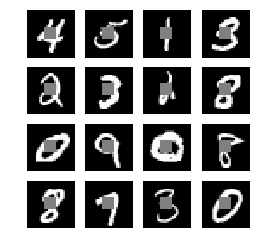

Imágenes reales


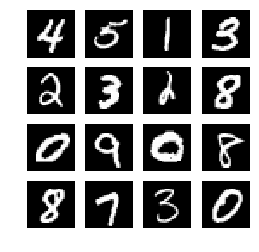

Imágenes de referencia


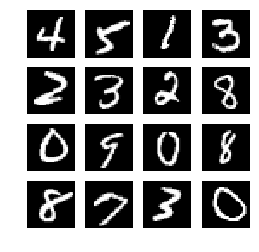

In [11]:
# Split validation images between masked and reference images.
VALIDATION_IMAGES_BOUNDRY = int(len(validation_set_images) * 0.5)

validation_images = validation_set_images[VALIDATION_IMAGES_BOUNDRY:,:,:,:]
validation_reference_images = validation_set_images[:VALIDATION_IMAGES_BOUNDRY,:,:,:]

validation_labels = validation_set_labels[VALIDATION_IMAGES_BOUNDRY:]
validation_reference_labels = validation_set_labels[:VALIDATION_IMAGES_BOUNDRY]

validation_reference_dict = create_reference_dictionary(validation_reference_labels)
validation_images_references = get_references(validation_reference_images,
                                              validation_labels, 
                                              validation_reference_dict)

# Save a subset of validation images for displaying
validation_images_subset = validation_images[:16]
validation_references = validation_images_references[:16]

validation_masked_images = []
for i, image in enumerate(validation_images_subset):
  masked_image, _, _ = mask(image, validation_references[i])
  validation_masked_images.append(masked_image.numpy())

validation_masked_images = np.array(validation_masked_images)

print("Imágenes enmascaradas")
show_and_save_images(validation_masked_images, 'validation_masked_images.png')
print("Imágenes reales")
show_and_save_images(validation_images_subset, 'validation_unmasked_images.png')
print("Imágenes de referencia")
show_and_save_images(validation_references, 'validation_reference_images.png')

## Creación de los modelos

### Generador

El generador recibe como entrada dos imágenes: una imágen enmascarada de un dígito, y otra imágen de referencia de ese mismo dígito. Su objetivo es regenerar las secciones faltantes en las imágenes enmascaradas de forma realista, tomando como referencia la segunda imagen. 

La arquitectura del generador consiste de dos Encoders y un Decoder. Un Encoder recibe la imágen enmascarada, y el otro Encoder recibe la imágen de referencia. Cada enconder consiste de 3 capas convolucionales, con Batch Normalization y Leaky ReLU.

Luego, los resultados de ambos encoders son concatenados y enviados al Decoder. El Decoder aplica 3 capas convolucionales transpuestas hasta generar una imágen del tamaño de la región faltante. Esta imágen será el output del generator.

In [12]:
class Generator(tf.keras.Model):
  def __init__(self):
    super(Generator, self).__init__()
    
    # Masked encoder
    self.mask_enc_conv_1 = tf.keras.layers.Conv2D(64, (5, 5),
                                                  strides=(1, 1), 
                                                  padding='same', 
                                                  input_shape=(28, 28, 1))
    self.mask_enc_bn_1 = tf.keras.layers.BatchNormalization()
    self.mask_enc_act_1 = tf.keras.layers.LeakyReLU()
    # 28x28x64
    
    self.mask_enc_conv_2 = tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')
    self.mask_enc_bn_2 = tf.keras.layers.BatchNormalization()
    self.mask_enc_act_2 = tf.keras.layers.LeakyReLU()
    # 14x14x64
        
    self.mask_enc_conv_3 = tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')
    self.mask_enc_bn_3 = tf.keras.layers.BatchNormalization()
    self.mask_enc_act_3 = tf.keras.layers.LeakyReLU()
    # 7x7x128

    
    # Reference encoder
    self.ref_enc_conv_1 = tf.keras.layers.Conv2D(64, (5, 5), 
                                                 strides=(1, 1), 
                                                 padding='same', 
                                                 input_shape=(28, 28, 1))
    self.ref_enc_bn_1 = tf.keras.layers.BatchNormalization()
    self.ref_enc_act_1 = tf.keras.layers.LeakyReLU()
    # 28x28x64
    
    self.ref_enc_conv_2 = tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')
    self.ref_enc_bn_2 = tf.keras.layers.BatchNormalization()
    self.ref_enc_act_2 = tf.keras.layers.LeakyReLU()
    # 14x14x64
        
    self.ref_enc_conv_3 = tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')
    self.ref_enc_bn_3 = tf.keras.layers.BatchNormalization()
    self.ref_enc_act_3 = tf.keras.layers.LeakyReLU()
    # 7x7x128
    
    
    # Decoder
    self.dec_conv_1 = tf.keras.layers.Conv2DTranspose(128, (5, 5), 
                                                      strides=(1, 1), 
                                                      padding='same', 
                                                      use_bias=False, 
                                                      input_shape=(7, 7, 256))
    self.dec_bn_1 = tf.keras.layers.BatchNormalization()
    self.dec_act_1 = tf.keras.layers.LeakyReLU()
    # 7x7x128

    self.dec_conv_2 = tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False)
    self.dec_bn_2 = tf.keras.layers.BatchNormalization()
    self.dec_act_2 = tf.keras.layers.LeakyReLU()
    # 7x7x64
    
    self.dec_conv_3 = tf.keras.layers.Conv2DTranspose(1, (5, 5), 
                                                      strides=(1, 1), 
                                                      padding='same', 
                                                      use_bias=False, 
                                                      activation='tanh')
    # 7x7x1

  def call(self, inputs, training=True):
    
    masked_image = inputs[0]
    reference_image = inputs[1]
    
    # Apply masked image encoder
    masked_encoding = self.mask_enc_conv_1(masked_image)
    masked_encoding = self.mask_enc_bn_1(masked_encoding, training=training)
    masked_encoding = self.mask_enc_act_1(masked_encoding)
        
    masked_encoding = self.mask_enc_conv_2(masked_encoding)
    masked_encoding = self.mask_enc_bn_2(masked_encoding, training=training)
    masked_encoding = self.mask_enc_act_2(masked_encoding)
        
    masked_encoding = self.mask_enc_conv_3(masked_encoding)
    masked_encoding = self.mask_enc_bn_3(masked_encoding, training=training)
    masked_encoding = self.mask_enc_act_3(masked_encoding)
        
    # Apply reference image encoder
    reference_encoding = self.mask_enc_conv_1(reference_image)
    reference_encoding = self.mask_enc_bn_1(reference_encoding, training=training)
    reference_encoding = self.mask_enc_act_1(reference_encoding)
        
    reference_encoding = self.mask_enc_conv_2(reference_encoding)
    reference_encoding = self.mask_enc_bn_2(reference_encoding, training=training)
    reference_encoding = self.mask_enc_act_2(reference_encoding)
        
    reference_encoding = self.mask_enc_conv_3(reference_encoding)
    reference_encoding = self.mask_enc_bn_3(reference_encoding, training=training)
    reference_encoding = self.mask_enc_act_3(reference_encoding)
    
    # Join both the masked and reference encoding
    encoding = tf.concat([masked_encoding, reference_encoding], axis=-1)
    
    # Apply the decoder to the joined encoding
    encoding = self.dec_conv_1(encoding)
    encoding = self.dec_bn_1(encoding, training=training)
    encoding = self.dec_act_1(encoding)
        
    encoding = self.dec_conv_2(encoding)
    encoding = self.dec_bn_2(encoding, training=training)
    encoding = self.dec_act_2(encoding)
    
    generated_patch = self.dec_conv_3(encoding)
    
    return generated_patch

### Discriminador

El discriminador recibe como entrada dos imágenes: una imágen que puede ser real o tener una sección regenerada por el generador, y otra imágen de referencia de ese mismo dígito. Su objetivo ees distinguir entre imágenes reales e imágenes regeneradas por el generador, basandose tanto en la primer imagen como en la imagen de referencia.

La arquitectura del discriminador consiste de dos Encoders y un clasificador. Uno de los encoders recibe la primer imágen (la cual puede ser real o generada), y el otro Encoder recibe la imágen de referencia. Cada enconder consiste de 2 capas convolucionales, con función de activación Leaky ReLU y Dropout.

Luego, los resultados de ambos encoders son concatenados y enviados al clasificador. El clasificador aplica 2 capas fully-connected para determinar si la primer imágen es real o falsa.

In [15]:
class Discriminator(tf.keras.Model):
  def __init__(self):
    super(Discriminator, self).__init__()
    
    # Image encoder
    self.img_enc_conv_1 = tf.keras.layers.Conv2D(64, (5, 5), 
                                                 strides=(2, 2), 
                                                 padding='same', 
                                                 input_shape=(28, 28, 1),
                                                 activation=tf.nn.leaky_relu)
    self.img_enc_drop_1 = tf.keras.layers.Dropout(0.3)
    # 14x14x64
      
    self.img_enc_conv_2 = tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', activation=tf.nn.leaky_relu)
    self.img_enc_drop_2 = tf.keras.layers.Dropout(0.3)
    # 7x7x128
     
    self.img_enc_flat = tf.keras.layers.Flatten()
    
    
    # Reference encoder
    self.ref_enc_conv_1 = tf.keras.layers.Conv2D(64, (5, 5), 
                                                 strides=(2, 2), 
                                                 padding='same', 
                                                 input_shape=(28, 28, 1),
                                                 activation=tf.nn.leaky_relu)
    self.ref_enc_drop_1 = tf.keras.layers.Dropout(0.3)
    # 14x14x64
      
    self.ref_enc_conv_2 = tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', activation=tf.nn.leaky_relu)
    self.ref_enc_drop_2 = tf.keras.layers.Dropout(0.3)
    # 7x7x128
     
    self.ref_enc_flat = tf.keras.layers.Flatten()
    
    
    # Classifier
    self.class_fc_1 = tf.keras.layers.Dense(1024, activation=tf.nn.leaky_relu)
    self.class_fc_2 = tf.keras.layers.Dense(1)
        

  def call(self, inputs, training=True):
    
    image = inputs[0]
    reference = inputs[1]
    
    # Apply masked image encoder
    img_encoding = self.img_enc_conv_1(image)
    img_encoding = self.img_enc_drop_1(img_encoding)
    
    img_encoding = self.img_enc_conv_2(img_encoding)
    img_encoding = self.img_enc_drop_2(img_encoding)
    
    img_encoding = self.img_enc_flat(img_encoding)
        
    # Apply reference image encoder
    ref_encoding = self.ref_enc_conv_1(reference)
    ref_encoding = self.ref_enc_drop_1(ref_encoding)
    
    ref_encoding = self.ref_enc_conv_2(ref_encoding)
    ref_encoding = self.ref_enc_drop_2(ref_encoding)
    
    ref_encoding = self.ref_enc_flat(ref_encoding)
        

    # Join both the image and reference encoding
    encoding = tf.concat([img_encoding, ref_encoding], axis=1)
    
    # Apply the classifier to the joined encoding
    encoding = self.class_fc_1(encoding)
    logits = self.class_fc_2(encoding)
    
    return logits

In [18]:
generator = Generator()
discriminator = Discriminator()

## Funciones de costo y optimizadores

A continuación se definen las funciones de costo para ambos modelos, y los optimizadores a utilizar para minimizar dichas funciones.

### Función de costo del generador
La función de costo del generador consiste de una función de Sigmoid Cross Entropy sobre las imágenes generadas. Se busca que la salida del discriminador sea 1 (reales) para dichas imágenes.

In [19]:
def generator_loss(generated_output):
    return tf.losses.sigmoid_cross_entropy(tf.ones_like(generated_output), generated_output)

### Función de costo del discriminador

La función de costo del discriminador tiene dos partes:
1. Costo sobre imágenes reales: consiste de una Sigmoid Cross Entropy sobre las imágenes reales. Se busca que la salida del discriminador sea 1 (reales) para dichas imágenes.
2. Costo sobre imágenes generadas: consiste de una Sigmoid Cross Entropy sobre las imágenes generadas por el generador. Se busca que la salida del discriminador sea 0 (falsas) para dichas imágenes.

Luego se suman estas dos funciones para obtener la función de costo del discriminador.

In [20]:
def discriminator_loss(real_output, generated_output):
    real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(real_output), logits=real_output)
    generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.zeros_like(generated_output), logits=generated_output)
    total_loss = real_loss + generated_loss
    return total_loss

### Optimizadores
Se utiliza un optimizador Adam para cada modelo, ya que estos se entrenan en paralelo.

In [21]:
generator_optimizer = tf.train.AdamOptimizer(1e-4)
discriminator_optimizer = tf.train.AdamOptimizer(1e-4)

## Checkpoints
Los parámetros de ambos modelos se almacenarán como checkpoints durante el entrenamiento, para poder recuperarlos luego.

In [22]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Configuración del entrenamiento

### Paso de entrenamiento

En cada paso del entrenamiento, el generador recibe un batch de imágenes enmascaradas junto con sus respectivas imágenes de referencias, y regenera las secciones faltantes. Estas regiones generadas son luego insertadas en las imágenes del batch, completando las secciones faltantes con las regiones generadas por el generador. Luego, el discriminador recibe por un lado estas imágenes con las secciones regeneradas junto con sus imágenes de referencia, y por otro lado un batch de imágenes reales, también con sus imágenes de referencia. 

A continuación, en base a los resultados del discriminador se calculan las funciones de costo de ambos modelos. Y finalmente, se aplica un paso de los optimizadores para cada modelo.

In [23]:
def patch_image(patch, image):
  """
  Apply the given patch to the image.
  The patch is applied at the center of the image, assuming a 7x7 patch and a 28x28 image.
  """
  # TODO: See if this could be done more efficiently.
  
  upper_edge = image[:, :10, :, :]
  lower_edge = image[:, 17:, :, :]
  
  middle_left = image[:, 10:17, :10, :]
  middle_right = image[:, 10:17, 17:, :]
  
  middle = tf.concat([middle_left, patch, middle_right], axis=2)
  return tf.concat([upper_edge, middle, lower_edge], axis=1)


In [24]:
def train_step(full_images, full_reference_images, masked_images, masked_reference_images):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    
    generated_patches = generator((masked_images, masked_reference_images), training=True)
    generated_images = patch_image(generated_patches, masked_images)
    
    real_output = discriminator((full_images, full_reference_images), training=True)
    generated_output = discriminator((generated_images, masked_reference_images), training=True)
    
    gen_loss = generator_loss(generated_output)
    disc_loss = discriminator_loss(real_output, generated_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))
  
  return gen_loss, disc_loss

Debido a que ejecutar el entrenamiento de forma secuencial suele ser más lento que ejecutar el grafo de operaciones equivalente, utilizamos la función [tf.contrib.eager.defun](https://www.tensorflow.org/api_docs/python/tf/contrib/eager/defun) para generar el grafo de operaciones y así obtener una mejora en la performance.

In [ ]:
train_step = tf.contrib.eager.defun(train_step)

### Proceso completo de entrenamiento
Aquí definimos el proceso completo de entrenamiento. Se itera sobre todo el dataset por cada epoch, y por cada batch del dataset se aplica un paso de entrenamiento. Luego de cada epoch, se muestran las imágenes de validación con las secciones regeneradas por el discriminador, y se grafican las funciones de costo de ambos modelos.

In [25]:
EPOCHS = 100

In [26]:
def train(dataset, epochs):
  gen_losses = []
  disc_losses = []
  for epoch in range(epochs):
    start = time.time()
    
    for images in dataset:
      (full_images, full_reference_images) = images[0]
      (masked_images, unmasked_images, masked_reference_images) = images[1]
      gen_loss, disc_loss = train_step(full_images, full_reference_images, masked_images, masked_reference_images)
    
    # Only store losses after each epoch
    gen_losses.append(gen_loss)
    disc_losses.append(disc_loss)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             validation_masked_images,
                             validation_references)
    plot_losses(gen_losses, disc_losses)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    print ('Time taken for epoch {} is {} sec'.format(epoch + 1,
                                                      time.time()-start))
  # generating after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           validation_masked_images,
                           validation_references)
  plot_losses(gen_losses, disc_losses)

In [27]:
def plot_losses(gen_loss, disc_loss): 
  plt.plot(range(1, len(gen_loss) + 1), gen_loss)
  plt.plot(range(1, len(disc_loss) + 1), disc_loss)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Generator and Discriminator Losses')
  plt.legend(['Gen loss', 'Disc loss'])
  plt.show()

In [28]:
def generate_and_save_images(generator, epoch, masked_images, reference_images):
  # make sure the training parameter is set to False because we
  # don't want to train the batchnorm layer when doing inference.
  patches = generator((masked_images, reference_images), training=False)
  generated_images = patch_image(patches, masked_images)
  
  show_and_save_images(generated_images, 'image_at_epoch_{:04d}.png'.format(epoch))

## Entrenamiento de la GAN

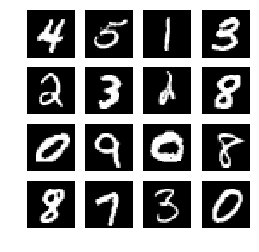

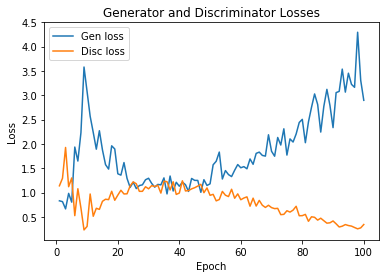

CPU times: user 58min 3s, sys: 16min 13s, total: 1h 14min 17s
Wall time: 2h 50min 34s


In [29]:
%%time
train(train_dataset, EPOCHS)

**Restauración del último checkpoint**

In [30]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Resultados

Luego del entrenamiento, visualizamos los resultados obtenidos.

In [31]:
# Display a single image using the epoch number
def display_image(name):
  return PIL.Image.open(name)

### Imágenes enmascaradas

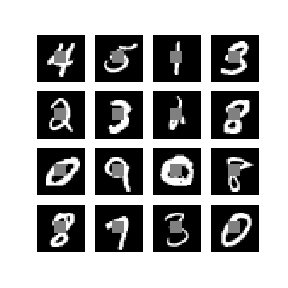

In [32]:
display_image('validation_masked_images.png')

### Imágenes de referencia

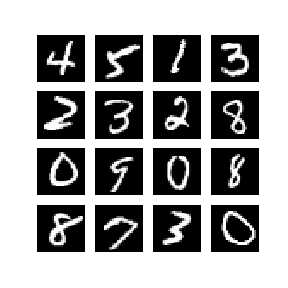

In [33]:
display_image('validation_reference_images.png')

### Imágenes generadas

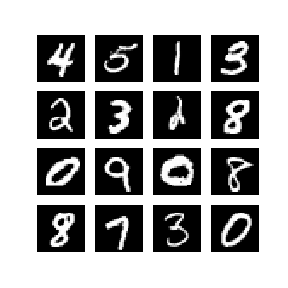

In [34]:
display_image('image_at_epoch_{:04d}.png'.format(EPOCHS))

### Imágenes reales

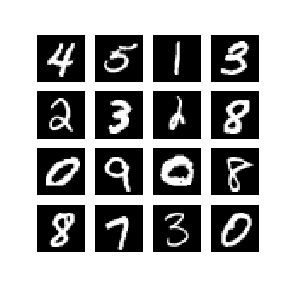

In [35]:
display_image('validation_unmasked_images.png')

### GIF del proceso de entrenamiento

A continuación generamos un gif mostrando la evolución del generador sobre las imágenes de validación.

In [ ]:
with imageio.get_writer('mnist-inpainting.gif', mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
    
# this is required in order to display the gif inside the notebook
os.system('cp mnist-inpainting.gif mnist-inpainting.gif.png')

In [ ]:
display.Image(filename="mnist-inpainting.gif.png")